In [1]:
DATA_PATH = '../QuMaDe1/data/out2'
MODEL_NAME = "model_on_80x80"
STATS_PATH = "./Models"
LIB_PATH = "."

#fgbg_images : 
fgbgmean = (0.43703552,0.43865393,0.42539937)#Calculated for this data
fgbgstd = (0.28416609,0.25724655,0.25717132)

#mask_images :
maskmean = (0.03939557,)
maskstd =  (0.19311964,)

#depth_images : 
depthmean = (0.55656881, )
depthstd =  (0.26315377,)

#size = (128,128)
size = (80,80)

In [2]:
mkdir Models

mkdir: cannot create directory ‘Models’: File exists


In [3]:
import sys
sys.path.append(f"{LIB_PATH}/EVALibrary")
sys.path.append(f"{LIB_PATH}/EVALibrary/EVA4")
sys.path.append(f"{LIB_PATH}/EVALibrary/EVA4/eva4models")


import warnings
warnings.filterwarnings("ignore")
import random
from tqdm.notebook import tqdm, trange
import os
import gc
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
import torch
from torch import nn
from utils import prepareData, displayData, show
from CustomData import CustomDataset




In [4]:
!pip install torchsummary
from torchsummary import summary

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
#Create directory of logs
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [7]:
data = prepareData(DATA_PATH)

In [8]:
#data = data[:5000]   #for testing everything is running or not
print('Dataset size :',len(data))
trainlen = int(len(data)*0.7)
print("Train set : ", trainlen)
print("Test set : ", len(data)-trainlen)
print("Sample Record in the data set.... Contains paths to bg, fgbg, mask and depth")
print(data[0])
#print(data[399999])

Dataset size : 400000
Train set :  280000
Test set :  120000
Sample Record in the data set.... Contains paths to bg, fgbg, mask and depth
('../QuMaDe1/data/out2/images/fgbg221360.jpg', '../QuMaDe1/data/out2/masks/mask221360.jpg', '../QuMaDe1/data/out2/depth/fgbg221360.jpg')


(224, 224) (224, 224) (224, 224)


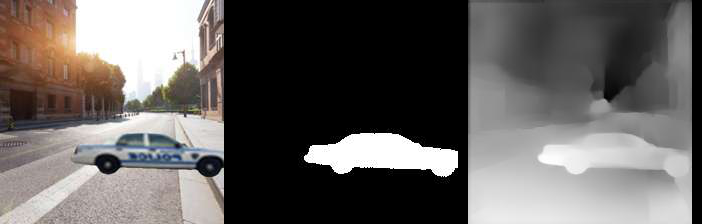

In [9]:
#Samplerecord display
displayData(data, 456)

In [10]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

 


fgbg_transforms = transforms.Compose([
         transforms.Resize(size),
         #transforms.RandomHorizontalFlip(),
         transforms.RandomRotation((-4, 4)),
         transforms.RandomGrayscale(p=0.05),
         transforms.ColorJitter(brightness=0.15, contrast=0.08, saturation=0.08, hue=0.08),
         transforms.ToTensor(),
         transforms.Normalize(fgbgmean, fgbgstd)                              
])


test_fgbgtransforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         transforms.Normalize(fgbgmean, fgbgstd)                              
])

mask_transforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         #transforms.Normalize(maskmean, maskstd)                              
])

depth_transforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         #transforms.Normalize(depthmean, depthstd)                              
])

In [11]:
train = CustomDataset(data[:trainlen],  fgbg_transforms, mask_transforms, depth_transforms)
test = CustomDataset(data[trainlen:], test_fgbgtransforms, mask_transforms, depth_transforms)
print(len(train), len(test))

280000 120000


In [12]:
import eva4dataloaders
batch_size=64

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size, shuffle=True)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [13]:
[(k, v.shape) for k, v in train[0].items()]

[('fgbg', torch.Size([3, 80, 80])),
 ('mask', torch.Size([1, 80, 80])),
 ('depth', torch.Size([1, 80, 80]))]

In [14]:
sample = next(iter(train_loader))
totalbatches = len(train_loader)
print('No.of batches :', totalbatches, 'Every sample contains :', len(sample))

No.of batches : 4375 Every sample contains : 3


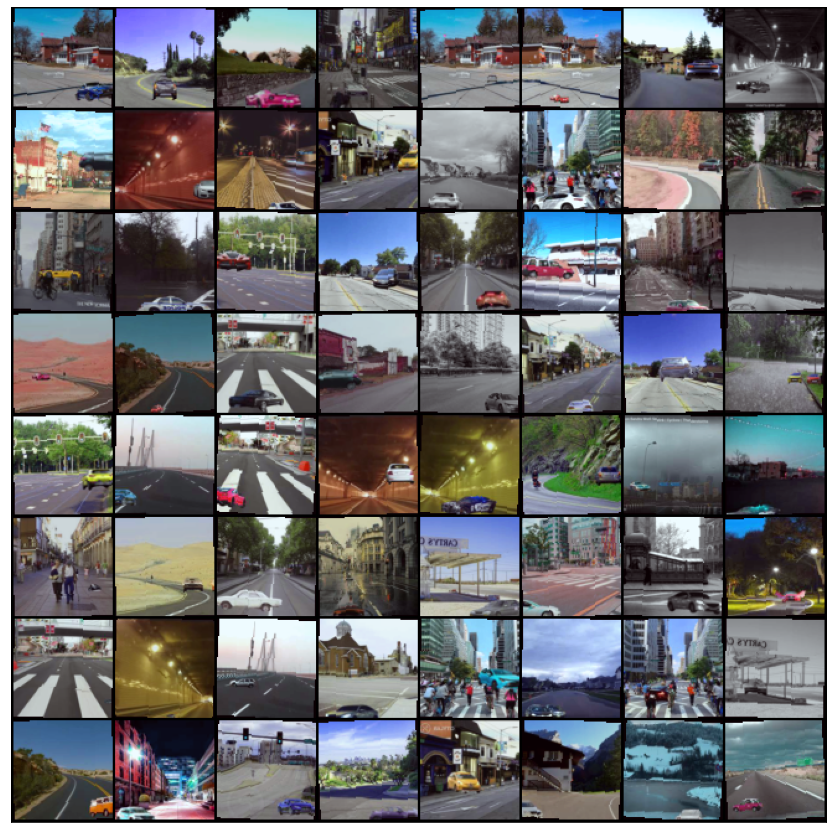

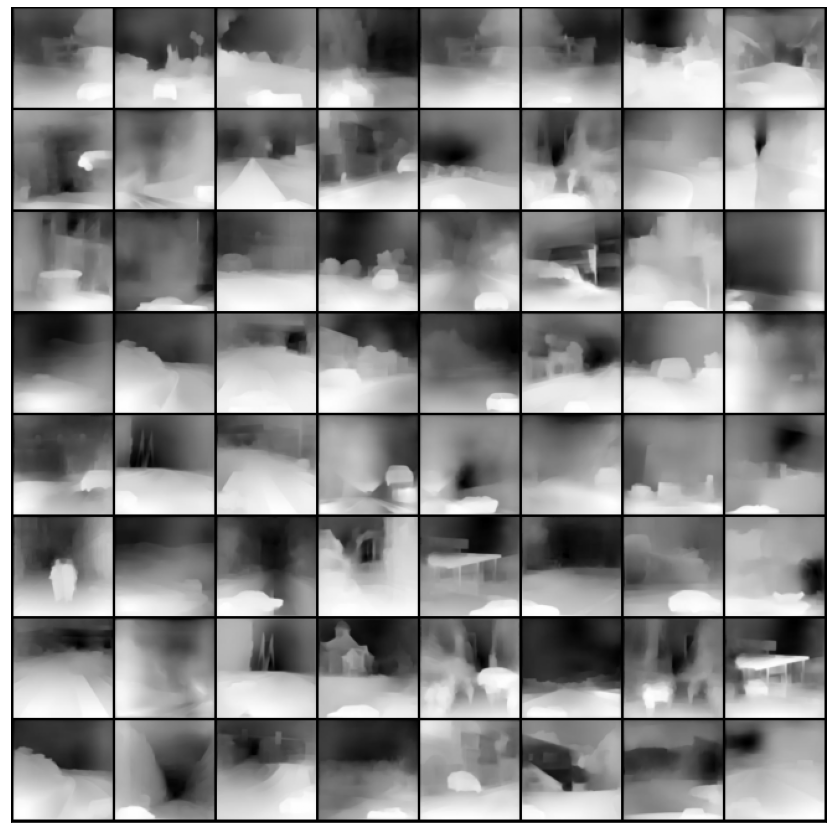

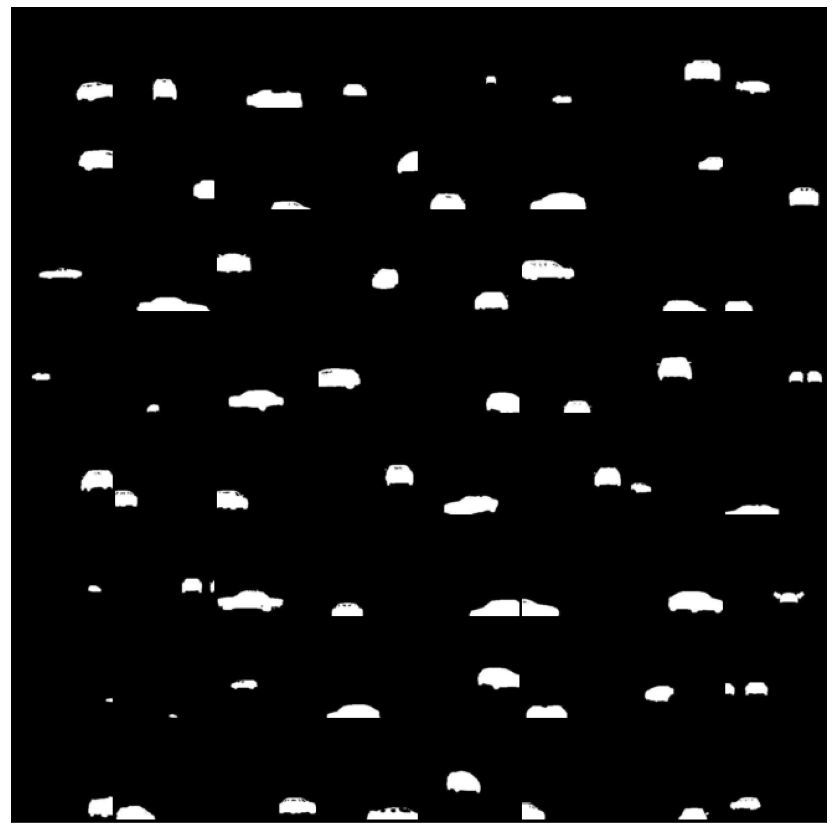

In [15]:
show(sample['fgbg'], normalize=True)
show(sample['depth'])
show(sample['mask'])

In [16]:
# Give a name to the model...
# This helps in saving the model and quantitative results for training as  well as testing data
name = MODEL_NAME

In [17]:
#from eva4models.eva4resnet import ResNet18
from loss import ssim
from lightmodel import S15Model
model = S15Model(name)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary(input_size=((3,224,224)))

Model parameters initialized
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 112, 112]          18,432
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           4,096
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]             576
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]           4,096
      Batc

In [ ]:
c1 = nn.L1Loss()   # combined with SSIM in train class
c2 = nn.L1Loss()   # combine with SSIM in train class
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum =0.9, nesterov=True, weight_decay = 1e-5 )
#from torch.optim.lr_scheduler import StepLR
device = torch.device('cuda:0')
model = model.to(device)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
L1lambda=0
EPOCHS = 10
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS, div_factor=10)
#scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 2)
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
#print("No.of steps to increase LR -", scheduler.step_size_up)
#print("No.of steps to reduce LR - ", scheduler.step_size_down)
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, STATS_PATH, scheduler, True, criterion1=c1, criterion2=c2)

Initial LR-  [0.009999999999999995]
Total steps -  43760


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]